In [1]:
from dotenv import load_dotenv
load_dotenv()

import os

In [135]:
from comet_ml import Experiment, Optimizer

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

torch.set_default_dtype(torch.float32)

In [3]:
from torchsummary import summary
import matplotlib.pyplot as plt

## Declare classes

In [4]:
class SimpleNetwork(torch.nn.Module):
    def __init__(self, inp_size, layers=[100]):
        super().__init__()
        self.layers = []
        
        self.inp = torch.nn.Linear(inp_size, layers[0])
        self.output = torch.nn.Linear(layers[0], 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x):
        out = x
        out = self.inp(out)
        out = self.relu(out)
        out = self.output(out)
        return out
    
class InsertableNet(SimpleNetwork):
    def __init__(self, weights, inp_size, layers=[100]):
        super().__init__(inp_size, layers)
        input_w_size = inp_size*layers[0]
        input_b_size = layers[0]

        hidden_w_size = layers[0]*10
        hidden_b_size = 10

        self.inp_weights = weights[:input_w_size].reshape((layers[0], inp_size))
        self.inp_bias = weights[input_w_size:input_w_size+input_b_size]

        self.output_weights = weights[input_w_size+input_b_size:input_w_size+input_b_size+hidden_w_size].reshape((10, layers[0]))
        self.output_bias = weights[input_w_size+input_b_size+hidden_w_size:input_w_size+input_b_size+hidden_w_size+hidden_b_size]

    def forward(self, data):
        out = F.linear(data, self.inp_weights, self.inp_bias)
        out = self.relu(out)
        out = F.linear(out, self.output_weights, self.output_bias)
        return out
    
class MaskedNetwork(SimpleNetwork):
    def __init__(self, input_size, mask_size, layers=[10]):
        super().__init__(mask_size, layers=layers)
        template = np.zeros(input_size)
        mask = np.random.choice(len(template), mask_size, False)
        template[mask] = 1
        self.mask = torch.from_numpy(template).to(torch.bool)
        
    def forward(self, x):
        data = x[:, self.mask]
        return super().forward(data)

In [174]:
class Hypernetwork(torch.nn.Module):
    def __init__(self, inp_size=784, mask_size=20, node_hidden_size=20, layers=[64, 256, 512], test_nodes=100):
        super().__init__()
        self.mask_size = mask_size
        self.input_size = inp_size
        self.node_hidden_size = node_hidden_size
        
        input_w_size = mask_size*node_hidden_size
        input_b_size = node_hidden_size

        hidden_w_size = node_hidden_size*10
        hidden_b_size = 10
            
        self.out_size = input_w_size+input_b_size+hidden_w_size+hidden_b_size
        
        self.input = torch.nn.Linear(inp_size, layers[0])
        self.hidden1 = torch.nn.Linear(layers[0], layers[1])
        self.hidden2 = torch.nn.Linear(layers[1], layers[2])
        self.out = torch.nn.Linear(layers[2], self.out_size)
        
        self.relu = torch.nn.ReLU()
        self.template = np.zeros(inp_size)
        self.test_nodes = test_nodes
        self.test_mask = self._create_mask(test_nodes)
        self.batchnorm = torch.nn.BatchNorm1d(layers[2])
        
        
    def forward(self, data, mask=None):
        if self.training:
            if mask is None:
                masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(len(data))])
                tmp = np.array([self.template.copy() for _ in range(len(data))])
                for i, mask in enumerate(masks):
                    tmp[i, mask] = 1
                mask = torch.from_numpy(tmp).to(torch.float32).cuda()

            weights = self.craft_network(mask)
            res = torch.zeros((len(data), 10)).cuda()
            for i in range(len(data)):
                nn = InsertableNet(weights[i], self.mask_size, layers=[self.node_hidden_size])
                masked_data = data[i, mask[i].to(torch.bool)]
                res[i] = nn(masked_data)
            return res
        else:
            if mask is None:
                mask = self.test_mask

            nets = []
            weights = self.craft_network(mask)
            res = torch.zeros((len(data), 10)).cuda()
            for i in range(len(mask)):
                nn = InsertableNet(weights[i], self.mask_size, layers=[self.node_hidden_size])
                masked_data = data[:, mask[i].to(torch.bool)]
                res += nn(masked_data)
            res /= self.test_nodes
            return res

#     def forward(self, data, mask=None):
#         if mask is None:
#             mask = np.random.choice(len(template), self.mask_size, False)
#             tmp = self.template.copy()
#             tmp[mask] = 1
#             mask = torch.from_numpy(tmp).to(torch.float32).cuda()
        
#         weights = self.craft_network(mask)
#         nn = InsertableNet(weights, self.mask_size, layers=[self.node_hidden_size])
#         masked_data = data[:, mask.to(torch.bool)]
#         return nn(masked_data)
        
    def _create_mask(self, count):
        masks = np.array([np.random.choice((len(self.template)), self.mask_size, False) for _ in range(count)])
        tmp = np.array([self.template.copy() for _ in range(count)])
        for i, mask in enumerate(masks):
            tmp[i, mask] = 1
        mask = torch.from_numpy(tmp).to(torch.float32).cuda()
        return mask
    
    def craft_network(self, mask):
        out = self.input(mask)
        out = self.relu(out)
        out = self.hidden1(out)
        out = self.relu(out)
        out = self.hidden2(out)
        out = self.relu(out)
        out = self.batchnorm(out)
        out = self.out(out)
        return out

In [175]:
hypernet = Hypernetwork(mask_size=20).cuda()

In [176]:
hypernet.eval()
hypernet(inputs)

tensor([[ 0.0163,  0.0128, -0.0344, -0.0116,  0.0313, -0.0156, -0.0415, -0.0247,
          0.0540,  0.0219],
        [ 0.0177,  0.0107, -0.0203, -0.0141,  0.0302, -0.0011, -0.0465, -0.0398,
          0.0579,  0.0282],
        [ 0.0156,  0.0078, -0.0184, -0.0116,  0.0319,  0.0018, -0.0454, -0.0428,
          0.0577,  0.0258],
        [ 0.0158,  0.0128, -0.0276, -0.0116,  0.0302, -0.0047, -0.0440, -0.0356,
          0.0563,  0.0252],
        [ 0.0146,  0.0105, -0.0229, -0.0105,  0.0315, -0.0024, -0.0456, -0.0394,
          0.0568,  0.0250],
        [ 0.0158,  0.0114, -0.0208, -0.0131,  0.0306, -0.0001, -0.0454, -0.0414,
          0.0575,  0.0277],
        [ 0.0118,  0.0112, -0.0290, -0.0088,  0.0338, -0.0111, -0.0402, -0.0332,
          0.0560,  0.0186],
        [ 0.0137,  0.0124, -0.0317, -0.0101,  0.0308, -0.0116, -0.0408, -0.0308,
          0.0537,  0.0193],
        [ 0.0144,  0.0122, -0.0410,  0.0010,  0.0277, -0.0171, -0.0404, -0.0256,
          0.0522,  0.0214],
        [ 0.0146,  

## Load data

In [6]:
mods = [transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)),    #mean and std of MNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
mods = transforms.Compose(mods)

trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)

In [7]:
batch_size = 32
test_batch_size = 1000

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=1)

## Craft model

In [164]:
def train_loop(hypernet, optimizer, epochs):
    train_loss = []
    test_loss = []
    for epoch in range(epochs): 
        total_loss = 0
        running_loss = 0.0
        correct = 0
        total = 0
        hypernet.train()
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()

            outputs = hypernet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            train_loss.append(loss.item())
            if i>0 and i % 100 == 0:
                total_loss += running_loss/100
                experiment.log_metric("batch_accuracy", correct / total * 100)

                running_loss = 0.0
                correct = 0
                total=0

        total_loss = 0
        correct = 0
        hypernet.eval()
        for i, data in enumerate(testloader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = hypernet(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).item()

        test_loss.append(total_loss/i)
        print(f"Test acc: {correct/len(testset)*100}")
        experiment.log_metric("test_accuracy", correct/len(testset)*100)

In [138]:
criterion = torch.nn.CrossEntropyLoss()

### Verify the model on a preset mask

In [70]:
hypernet = Hypernetwork(mask_size=20).cuda()

In [71]:
input_size = 784
mask_size = 20

template = np.zeros(input_size)
mask = np.random.choice(len(template), mask_size, False)
template[mask] = 1
mask = torch.from_numpy(template).to(torch.float32).cuda()

In [72]:
mask.sum()

tensor(20., device='cuda:0')

In [73]:
epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)

In [74]:
train_loss = []
test_loss = []
for epoch in range(epochs): 
    total_loss = 0
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        outputs = hypernet(inputs, mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        correct += (outputs.argmax(1)==labels).float().sum()
        total += outputs.shape[0]
        running_loss += loss.item()
        train_loss.append(loss.item())
        if i>0 and i % 100 == 0:
            total_loss += running_loss/100
            running_loss = 0.0
            correct = 0
            total=0

    total_loss = 0
    correct = 0
    for i, data in enumerate(testloader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = hypernet(images, mask)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total_loss += criterion(outputs, labels).item()
        
    test_loss.append(total_loss/i)
    print(f"Test acc: {correct/len(testset)*100}")

Test acc: 51.53
Test acc: 52.53
Test acc: 52.949999999999996
Test acc: 53.0
Test acc: 53.53


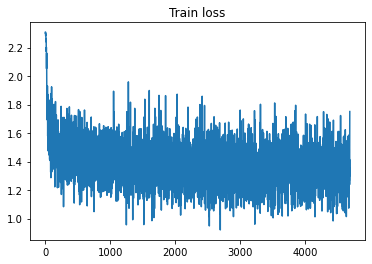

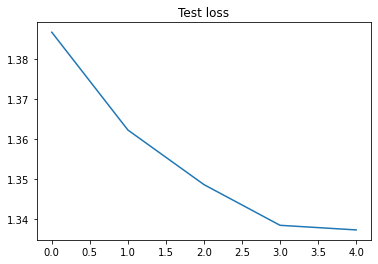

In [76]:
plt.title("Train loss")
plt.plot(train_loss);
plt.show()
plt.title("Test loss")
plt.plot(test_loss);

### Bayesian hyperparam search

In [ ]:
config = {
    "algorithm": "bayes",
    "parameters": {
        "l1": {"type": "categorical", "values": ["64"]},
        "l2": {"type": "categorical", "values": ["256"]},
        "l3": {"type": "categorical", "values": ["256"]},
        "learning_rate": {"type": "float", "min": 0.0001, "max": 0.1, "scalingType": "loguniform"},
        "learning_rate2": {"type": "float", "min": 0.0001, "max": 0.1, "scalingType": "loguniform"},
        "batch_size": {"type": "categorical", "values": ["32", "64"]},
    },
    "spec": {
    "metric": "loss",
    "objective": "minimize",
    },
}

opt = Optimizer(config, api_key=os.environ.get("COMET_KEY"))
criterion = torch.nn.CrossEntropyLoss()

for experiment in opt.get_experiments(project_name="hypernetwork"):
    experiment.add_tag("optimization")

    batch_size = int(experiment.get_parameter("batch_size"))
    test_batch_size = 1000

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=1)
    testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                             shuffle=False, num_workers=1)
    
    hypernet = Hypernetwork(mask_size=30, layers=[
            int(experiment.get_parameter("l1")), 
            int(experiment.get_parameter("l2")), 
            int(experiment.get_parameter("l3"))
    ]).cuda()
    
    
    optimizer = torch.optim.Adam(hypernet.parameters(), lr=experiment.get_parameter("learning_rate"))
    train_loop(hypernet, optimizer, 10)
    
    optimizer = torch.optim.Adam(hypernet.parameters(), lr=experiment.get_parameter("learning_rate2"))
    train_loop(hypernet, optimizer, 10)
    experiment.end()

COMET INFO: COMET_OPTIMIZER_ID=af5d4054532f4588b05a7fe2f633923d
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': 'af5d4054532f4588b05a7fe2f633923d', 'lastUpdateTime': None, 'maxCombo': 0, 'name': 'af5d4054532f4588b05a7fe2f633923d', 'parameters': {'batch_size': {'type': 'categorical', 'values': ['32', '64']}, 'l1': {'type': 'categorical', 'values': ['64']}, 'l2': {'type': 'categorical', 'values': ['256']}, 'l3': {'type': 'categorical', 'values': ['256']}, 'learning_rate': {'max': 0.1, 'min': 0.0001, 'scalingType': 'loguniform', 'type': 'float'}, 'learning_rate2': {'max': 0.1, 'min': 0.0001, 'scalingType': 'loguniform', 'type': 'float'}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 0, 'metric': 'loss', 'minSampleSize': 100, 'objective': 'minimize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 24408188546, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'seq

Test acc: 15.629999999999999
Test acc: 21.6
Test acc: 21.75
Test acc: 25.09
Test acc: 25.44
Test acc: 31.269999999999996
Test acc: 34.12
Test acc: 40.07
Test acc: 49.230000000000004
Test acc: 53.52
Test acc: 56.510000000000005
Test acc: 54.0
Test acc: 60.84
Test acc: 65.53
Test acc: 62.03999999999999
Test acc: 66.59
Test acc: 67.5
Test acc: 68.60000000000001
Test acc: 67.47999999999999
Test acc: 70.78999999999999


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/5115a10db3d34f7fae3744f325517a7f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_accuracy [360] : (10.3125, 32.34375)
COMET INFO:     loss [3750]          : (1.468428611755371, 8.426197052001953)
COMET INFO:     test_accuracy [20]   : (15.629999999999999, 70.78999999999999)
COMET INFO:   Others:
COMET INFO:     optimizer_count        : 1
COMET INFO:     optimizer_id           : af5d4054532f4588b05a7fe2f633923d
COMET INFO:     optimizer_metric       : loss
COMET INFO:     optimizer_metric_value : 1.468428611755371
COMET INFO:     optimizer_objective    : minimum
COMET INFO:     optimizer_parameters   : {"batch_size": "32", "l1": "64", "l2": "256", "l3": "256", "learning_rate": 0.0006065198335809262, "learning

Test acc: 27.48
Test acc: 30.049999999999997
Test acc: 36.19
Test acc: 36.42
Test acc: 39.43
Test acc: 42.13
Test acc: 44.26
Test acc: 53.410000000000004
Test acc: 52.32
Test acc: 56.28999999999999
Test acc: 41.43
Test acc: 46.5
Test acc: 51.980000000000004
Test acc: 57.03
Test acc: 61.59
Test acc: 62.09
Test acc: 63.190000000000005
Test acc: 62.870000000000005
Test acc: 64.73
Test acc: 67.71000000000001


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/f33c0ba3788345cebb170079f3dbd22f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_accuracy [180] : (10.009282112121582, 30.671873092651367)
COMET INFO:     loss [1876]          : (1.6984798908233643, 6.131765365600586)
COMET INFO:     test_accuracy [20]   : (27.48, 67.71000000000001)
COMET INFO:   Others:
COMET INFO:     optimizer_count        : 2
COMET INFO:     optimizer_id           : af5d4054532f4588b05a7fe2f633923d
COMET INFO:     optimizer_metric       : loss
COMET INFO:     optimizer_metric_value : 1.6984798908233643
COMET INFO:     optimizer_objective    : minimum
COMET INFO:     optimizer_parameters   : {"batch_size": "64", "l1": "64", "l2": "256", "l3": "256", "learning_rate": 0.0001560250572212303,

Test acc: 23.87
Test acc: 33.98
Test acc: 32.15
Test acc: 41.010000000000005
Test acc: 37.63
Test acc: 47.38
Test acc: 50.970000000000006
Test acc: 56.64
Test acc: 56.89999999999999
Test acc: 59.79
Test acc: 9.75
Test acc: 10.05
Test acc: 8.95
Test acc: 10.32
Test acc: 9.82
Test acc: 9.76
Test acc: 10.100000000000001
Test acc: 9.82
Test acc: 10.59
Test acc: 9.62


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/a32bb99a57e74024a95183a448718a64
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_accuracy [360] : (8.40625, 26.28125)
COMET INFO:     loss [3750]          : (1.7465291023254395, 1386678.375)
COMET INFO:     test_accuracy [20]   : (8.95, 59.79)
COMET INFO:   Others:
COMET INFO:     optimizer_count        : 3
COMET INFO:     optimizer_id           : af5d4054532f4588b05a7fe2f633923d
COMET INFO:     optimizer_metric       : loss
COMET INFO:     optimizer_metric_value : 1.7465291023254395
COMET INFO:     optimizer_objective    : minimum
COMET INFO:     optimizer_parameters   : {"batch_size": "32", "l1": "64", "l2": "256", "l3": "256", "learning_rate": 0.00014995238610792926, "learning_rate2": 0.09628356534720327}

Test acc: 32.6
Test acc: 30.75
Test acc: 39.989999999999995
Test acc: 42.72


### Train the full model

In [159]:
batch_size = 32
test_batch_size = 1000

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=1)

hypernet = Hypernetwork(mask_size=30, layers=[64, 256]).cuda()

In [161]:
experiment = Experiment(api_key=os.environ.get("COMET_KEY"), project_name="hypernetwork")
experiment.add_tag("training")

epochs = 50
optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)
train_loop(hypernet, optimizer, epochs)
epochs = 50
optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-5)
train_loop(hypernet, optimizer, epochs)
epochs = 50
optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-5)
train_loop(hypernet, optimizer, epochs)
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/hypernetwork/2fa25dfce9c349018d0c007ab861dfff
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (116.41 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages              : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/5c29

Test acc: 55.720000000000006
Test acc: 54.43
Test acc: 61.96
Test acc: 64.4
Test acc: 67.89
